In [909]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [910]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied

In [911]:
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY = HPI_PO.YoY.astype(float)

In [912]:
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates


In [913]:
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)

In [914]:
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)

In [915]:
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values

In [916]:
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [917]:
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover

In [918]:
HCAI = pd.read_excel("HCAI.xlsx", sheet_name="Whole Market")
HCAI
new_header = HCAI.loc[2]
HCAI = HCAI[3:]
HCAI.columns = new_header
HCAI = HCAI[HCAI.columns[:6]]
HCAI.rename(columns={"Year" : "DATE"}, inplace=True)
HCAI.DATE = HCAI.DATE.apply(lambda x: str(x).split()[0])
DATE = HCAI.DATE.values
Quarter = HCAI.Quarter.values
new_dates = []
for i in range(len(DATE)):
    if Quarter[i] == 1:
        new_dates.append(DATE[i]+"-01-01")
    elif Quarter[i] == 2:
        new_dates.append(DATE[i]+"-04-01")
    elif Quarter[i] == 3:
        new_dates.append(DATE[i]+"-07-01")
    elif Quarter[i] == 4:
        new_dates.append(DATE[i]+"-10-01")
    else:
        raise ValueError("Invalid value for quarter")
HCAI.DATE = new_dates
HCAI.DATE = pd.to_datetime(HCAI.DATE)
HCAI.columns = [x.replace("\n", '') for x in HCAI.columns.to_list()]
HCAI = HCAI.iloc[4:,[0,3]]
df = pd.merge(HPI_PO, HCAI, on='DATE', how='outer')
#df.dropna(subset=["Implied_Turnover"], inplace = True)
df.fillna(method='ffill',inplace= True)

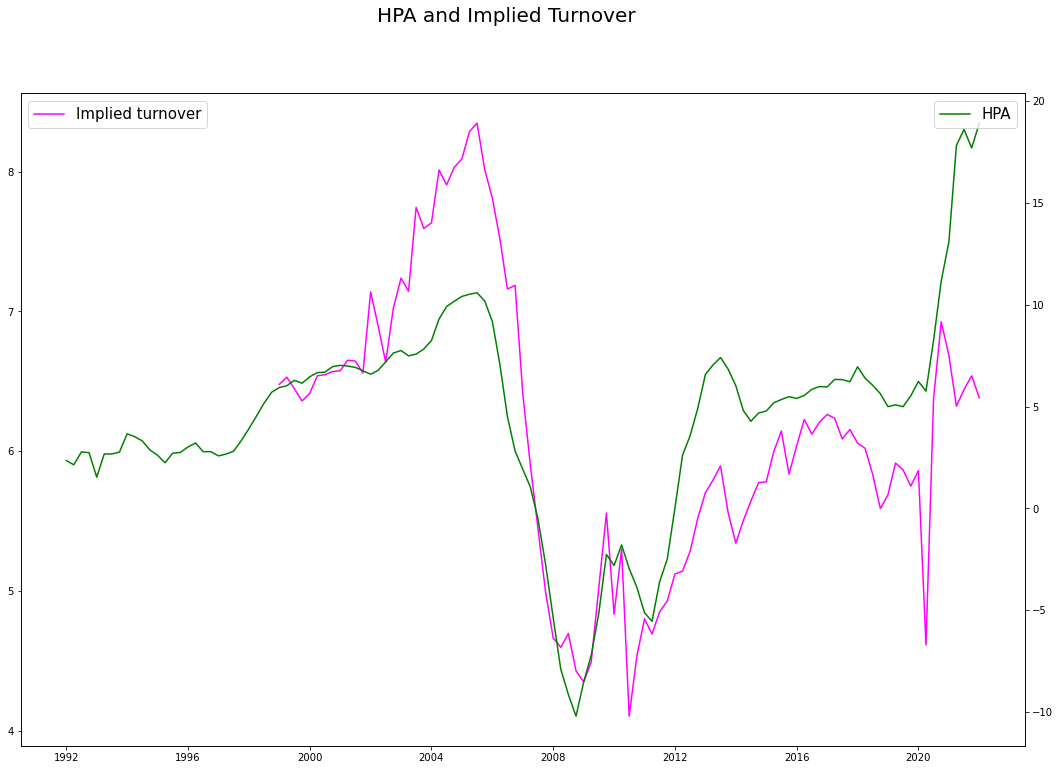

In [919]:
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(df.DATE, df.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'magenta')
ax2 = ax1.twinx()
ax2.plot(df.DATE, df.YoY, linewidth=1.5,color='green',label='HPA')
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
fig.suptitle("HPA and Implied Turnover", size = 20)
plt.show()
fig.savefig("HPIvsIT.png")

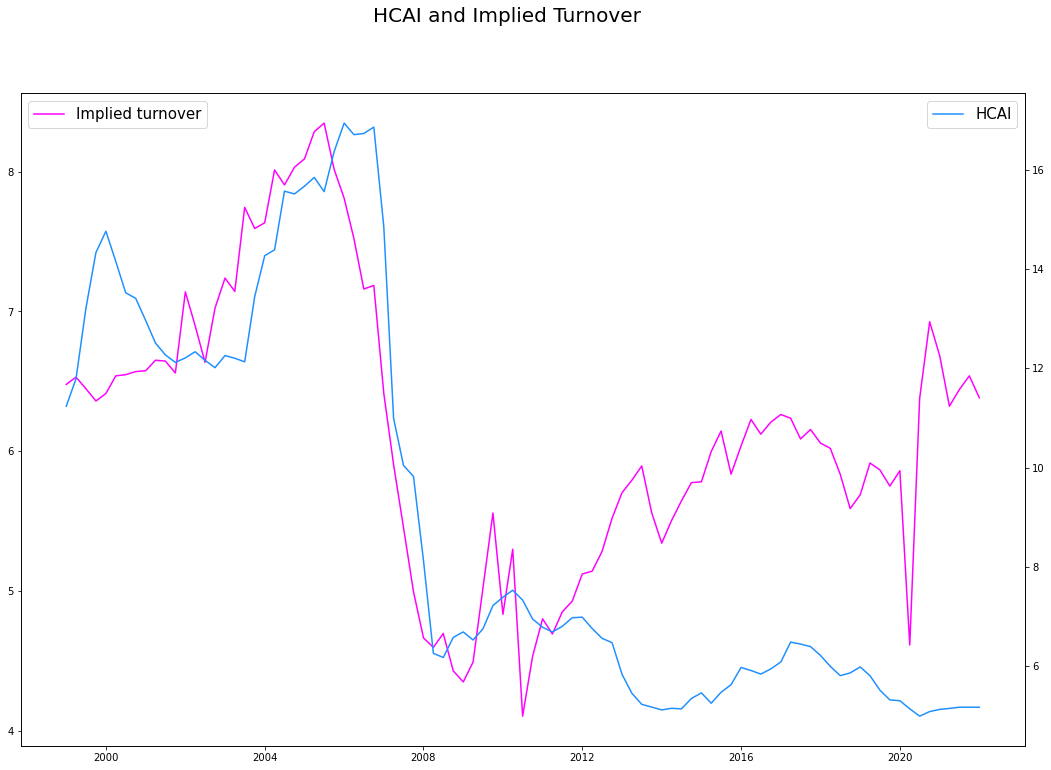

In [920]:
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(df.DATE, df.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'magenta')
ax2 = ax1.twinx()
ax2.plot(df.DATE,df.TotalRisk, linewidth=1.5,color='dodgerblue',label='HCAI')
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
fig.suptitle("HCAI and Implied Turnover", size = 20)
plt.show()
fig.savefig("HCAIvsIT.png")

## Selecting most effective predictors

In [921]:
import statsmodels.api as sm

ModelDescription ={}
for i in range(1,YoY_windows):
    s="YoY_MA_Window%i"%i
    df[s] = df.YoY.rolling(i).mean()
    data = df.dropna(subset=["Implied_Turnover"])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm =sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data = data).fit()
    ModelDescription[model_name]["model"] = lm
    
for j in range(1, TR_windows):
    s = "TR_MA_Window%i"%j
    df[s] = df.TotalRisk.rolling(j).mean()
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm =sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data = data).fit()
    ModelDescription[model_name]["model"] = lm

for lag in range(1,lags):
    s = "YoY_Lag%i"%lag
    df[s] = df.YoY.shift(lag)
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm = sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data= data).fit()
    ModelDescription[model_name]["model"] = lm
for lag in range(1,lags):
    s = "TR_Lag%i"%lag
    df[s] = df.TotalRisk.shift(lag)
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm = sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data= data).fit()
    ModelDescription[model_name]["model"] = lm

In [922]:
for i in (ModelDescription.values()):
    print(i["Features"], )
    print('R_squared = ',i["model"].rsquared,'\n\n')

YoY_MA_Window1
R_squared =  0.525476372907772 


YoY_MA_Window2
R_squared =  0.5429542948729017 


YoY_MA_Window3
R_squared =  0.5595540470478273 


YoY_MA_Window4
R_squared =  0.574113051242837 


YoY_MA_Window5
R_squared =  0.5875685330163019 


YoY_MA_Window6
R_squared =  0.5967890004441652 


YoY_MA_Window7
R_squared =  0.6004509257356379 


YoY_MA_Window8
R_squared =  0.6001470541875815 


YoY_MA_Window9
R_squared =  0.595656649248811 


YoY_MA_Window10
R_squared =  0.5884931910186406 


YoY_MA_Window11
R_squared =  0.5793009756928469 


TR_MA_Window1
R_squared =  0.5022529310514938 


TR_MA_Window2
R_squared =  0.477244062645132 


TR_MA_Window3
R_squared =  0.4504007422555968 


TR_MA_Window4
R_squared =  0.42084640365366943 


TR_MA_Window5
R_squared =  0.38956648330365495 


TR_MA_Window6
R_squared =  0.3571370440801769 


TR_MA_Window7
R_squared =  0.32463176257480175 


TR_MA_Window8
R_squared =  0.29382227844998543 


TR_MA_Window9
R_squared =  0.26435325983703606 


TR_MA_

In [923]:
data = df.dropna(subset= ["Implied_Turnover", "TotalRisk"])
lm = sm.OLS.from_formula("Implied_Turnover ~ TotalRisk+ YoY_MA_Window6", data = data.iloc[:-10,:]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Implied_Turnover   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     235.0
Date:                Sun, 24 Jul 2022   Prob (F-statistic):           3.24e-34
Time:                        14:08:36   Log-Likelihood:                -40.619
No. Observations:                  83   AIC:                             87.24
Df Residuals:                      80   BIC:                             94.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.4747      0.117     38.290      0.000       4.242       4.707
TotalRisk          0.1237      0.013      9.428      0.000       0.098       0.150
YoY_MA_Window6     0.1251      0.011     11.783      0.000       0.104       0.146
==============================================================================
Omnibus:                        0.190   Durbin-Watson:                   0.505
Prob(Omnibus):                  0.909   Jarque-Bera (JB):                0.296
Skew:                           0.106   Prob(JB):                        0.862
Kurtosis:                       2.799   Cond. No.                         30.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [926]:
#data[["TotalRisk", "YoY_MA_Window6"]].iloc[-10:,:]
pred = lm.predict(data[["TotalRisk", "YoY_MA_Window6"]].iloc[-10:,:])
np.sqrt(mean_squared_error(pred,data.Implied_Turnover.iloc[-10:]))

0.6038242346867396

In [873]:
weights = np.array([0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
X_YoY["YoY_weigheted_MA"] = X_YoY.YoY.rolling(6).apply(lambda x: np.sum(weights*x)).head(10)